In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Modify this
TRAIN_DATASET_PATH = '/content/drive/MyDrive/digitalent/dsc2024/data/elongated_word_10k.csv'
VALIDATION_DATASET_PATH = '/content/drive/MyDrive/digitalent/dsc2024/data/val_10k.csv'
MODEL_SAVE_PATH = '/content/drive/MyDrive/digitalent/dsc2024/xgboost/models/xgboost_pipeline.pkl'

Mounted at /content/drive


In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from xgboost import XGBClassifier

In [4]:
data = pd.read_csv(TRAIN_DATASET_PATH)
data['news'] = data['news'].astype(str)
X = data['news']
y = data['is_fake']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
pipe_xgboost = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("classifier", XGBClassifier(eval_metric='logloss', random_state=42)),
    ],
    verbose=True,
)

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

scoring = "accuracy"

scores_xgboost = cross_val_score(pipe_xgboost, X_train, y_train, scoring=scoring, cv=cv)
print(f"{scoring}: %0.2f (+/- %0.2f)" % (scores_xgboost.mean(), scores_xgboost.std() * 2))

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  19.6s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  21.8s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  20.6s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.6s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  19.3s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  21.6s
accuracy: 0.95 (+/- 0.01)


In [6]:
pipe_xgboost.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   1.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  25.0s


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))],
         verbose=True)

In [7]:
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(pipe_xgboost, file)

In [8]:
val_data = pd.read_csv(VALIDATION_DATASET_PATH)
val_data['news'] = val_data['news'].astype(str)
X_val = val_data['news']
y_val = val_data['is_fake']


Holdout Accuracy: 0.95

Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1000
           1       0.93      0.97      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



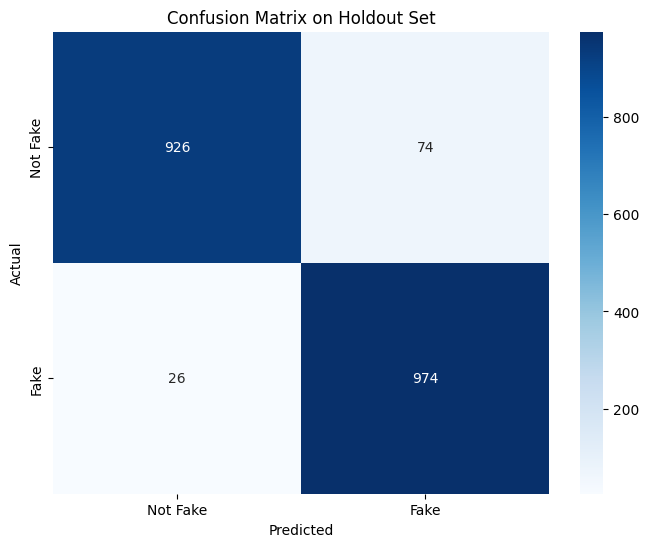

In [9]:
y_pred = pipe_xgboost.predict(X_holdout)
print("\nHoldout Accuracy:", accuracy_score(y_holdout, y_pred))
print("\nClassification Report on Holdout Set:")
print(classification_report(y_holdout, y_pred))
cfm = confusion_matrix(y_holdout, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Holdout Set')
plt.show()


Validation Accuracy: 0.9730348096094134

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2900
           1       0.97      0.98      0.97      3219

    accuracy                           0.97      6119
   macro avg       0.97      0.97      0.97      6119
weighted avg       0.97      0.97      0.97      6119



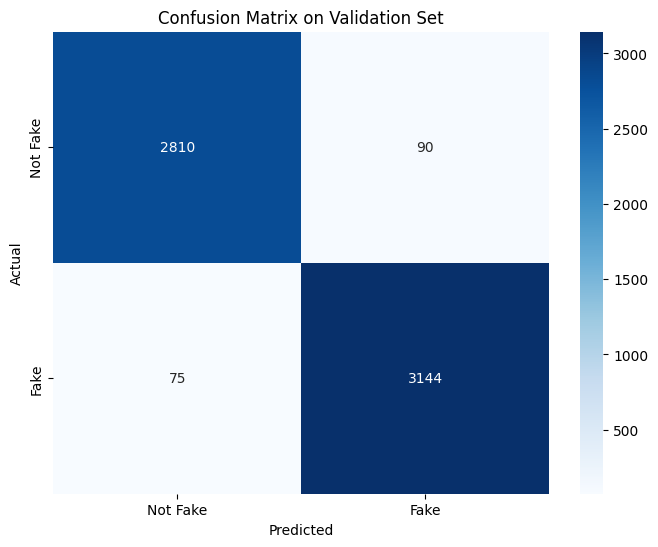

In [10]:
y_val_pred = pipe_xgboost.predict(X_val)
print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))
cfm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm_val, fmt='.0f', annot=True, cmap='Blues',
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()